# Envisioning Dante - Detection of Visual Elements with D526-v3

## 1 - Read Me First

This project is a [Jupyter](https://jupyter.org/) notebook and was
designed to run in [Google
Colab](https://colab.research.google.com/).  If you are not reading
this notebook in Google Colab, click
[here](https://colab.research.google.com/github/ox-vgg/demo-notebooks/blob/main/notebooks/workshops/envdante-detector-out-of-domain-test.ipynb).

### 1.1 - What is, and how to use, a Jupyter notebook

A Jupyter notebook is a series of "cells".  Each cell contains
either text (like this one) or code (like others below).  A cell
that contains code will have a "Run cell" button on the left side
like this "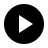".
When you click the "Run cell" button the code in that cell will run.
When it finishes running, a small green check mark appears next to
the "Run cell" button".  You need to wait for the code in that cell
to finish before "running" the next cell.

Typically, you run the cells one after the other since each cell is
dependent on the results of the previous cell.

### 1.2 - Particulars of this notebook

This notebook detects a series of page elements on images of book
pages.  It was trained on 526 pages from 18 different volumes of
Dante Alighieri's "Comedy", printed between 1470 and 1629.  It
detects the following classes:

  - catchword-signature
  - graphic
  - initial-capital
  - manicules
  - page-number
  - poem
  - prose
  - running-header
  - section-header
  - sideletter
  - sidenote
  - unpainted-guideletter

It takes as input a
[VIA3](https://www.robots.ox.ac.uk/~vgg/software/via/app/via_image_annotator.html)
project ID with a attribute named "class" with those class names as
options.  It will report AP values for those annotations.

### 1.3 - GPU access

A GPU is not required to run this program but without a GPU it will
run much slower.  Depending on the amount of data to analyse, it
might not be sensible to use it without a GPU.  For reference, a
single image takes about 0.2 seconds to analyse with a GPU.  On a
CPU, the same image takes about 15 seconds (75 times slower).

By default, this notebook will run with a GPU.  However, it is
possible that you were not allocated one, typically because you've
used up all your GPU resources.  You can confirm this, and possibly
change it, manually.  To do that, navigate to "Edit" -> "Notebook
Settings" and select "GPU" from the "Hardware Accelerator" menu.

## 2 - Setup

### 2.1 - Check for GPU access

In [ ]:
#@markdown By default, this notebook will run with a GPU.  However, it
#@markdown is possible that you were not allocated one.  If you get a
#@markdown message saying that you do not have access to a GPU,
#@markdown navigate to "Edit" -> "Notebook Settings" and select "GPU"
#@markdown from the "Hardware Accelerator" menu.  If you change it,
#@markdown you need to run this cell again.

# We do this before everything else, namely before installing
# detectron2 (which takes a lot of time), to identify early the case
# of accidentally running this without a GPU.
import torch.cuda

if torch.cuda.is_available():
    USE_GPU = True
    print(
        "You are using GPU id %d: %s (%d GB)"
        % (
            torch.cuda.current_device(),
            torch.cuda.get_device_name(),
            torch.cuda.get_device_properties(
                torch.cuda.current_device()
            ).total_memory
            * 1e-9,
        )
    )
else:
    USE_GPU = False
    print("You are NOT connected to a GPU")
    print("Consider reconnecting to a runtime with GPU access.")

### 2.2 - Install dependencies

In [ ]:
#@markdown This step can take a few of minutes to finish.  It
#@markdown downloads and installs software that is not available by
#@markdown default on Google Colab.

# Using `pip install --quiet` is not enough, it still prints out a
# bunch of messages which is why we redirect stdout to `/dev/null`.
# Important messages should go to stderr anyway.

!pip install --quiet python-via > /dev/null

# Detectron2 is not available on PyPI, we have to install it from
# their git repos.
!pip install --quiet git+https://github.com/facebookresearch/detectron2.git > /dev/null

### 2.3 - Load dependencies and configure

In [ ]:
#@markdown This cell prepares the detector to run.  This is the place
#@markdown to make changes to the code if you want (but you should not
#@markdown need to).

DETECTRON2_CONFIG = "https://thor.robots.ox.ac.uk/staging/env-dante/mask-rcnn-R-50-FPN-D526v3-2024-11-13.py"
MODEL_CKPT = "https://thor.robots.ox.ac.uk/staging/env-dante/mask-rcnn-R-50-FPN-D526v3-2024-09-05.pth"
VIA3_VPS_URL = "https://zeus.robots.ox.ac.uk/via/store/3.x.y/"
BATCH_SIZE = 1  # increasing this does not seem to make things any faster :/

import contextlib
import copy
import json
import logging
import os
import os.path
import re
import time
import urllib.parse
import warnings
from dataclasses import dataclass
from typing import Dict, TypedDict
from zipfile import ZipFile

import PIL.Image
import detectron2.checkpoint
import detectron2.config
import detectron2.data
import detectron2.data.catalog
import detectron2.data.detection_utils
import detectron2.data.transforms
import detectron2.structures.masks
import detectron2.utils.visualizer
import numpy as np
import pycocotools.coco
import pycocotools.cocoeval
import pycocotools.mask
import requests
import torch
import torch.utils.data
import via.coco
import via.vfs

import google.colab.output
import google.colab.files
from google.colab.patches import cv2_imshow


_logger = logging.getLogger()
logging.basicConfig()


## XXX: Detectron2 has not fixed, and does not look interested in
## fixing, this issue
## https://github.com/facebookresearch/detectron2/issues/3786
## https://github.com/facebookresearch/detectron2/pull/4531 So silence
## to avoid scaring users.
warnings.filterwarnings(
    "ignore",
    message="torch\.meshgrid: in an upcoming release, it will be required to pass the indexing argument\. \(Triggered internally at \.\./aten/src/ATen/native/TensorShape\.cpp",
    category=UserWarning,
    module="torch.functional",
)


## VIA3 still uses a VPS server and not VFS so we monkeypatch via.vfs
## to support it
class VPSProjectInfo(TypedDict):
    pid: str
    rev: str
    rev_timestamp: str


via.vfs.ProjectInfo = VPSProjectInfo
via.vfs.is_project = lambda x: True


def via3_make_files_local(via3_dict):
    """Beware! This edits via3_dict.

    This downloads all files to cwd and edits file src and loc prefix.
    """
    loc_prefix = via3_dict["config"]["file"]["loc_prefix"]

    fpaths = set()
    url_to_fpath = {}

    loc_prefix = via3_dict["config"]["file"]["loc_prefix"]
    for via3_file in via3_dict["file"].values():
        if via3_file["loc"] == 4:  # inline
            msg = f"Inline images are not supported (fid {via3_file['fid']})"
            _logger.error(msg)
            raise Exception(msg)
        prefix = loc_prefix[str(via3_file["loc"])]
        url = prefix + via3_file["src"]
        if not re.match("https?://", url):
            msg = f"All images must be over https (got '{url}')"
            _logger.error(msg)
            raise Exception(msg)
        fpath = os.path.basename(urllib.parse.urlparse(url).path)
        if fpath in fpaths:
            mgs = f"Found two images with same filename {fpath}"
            _logger.error(msg)
            raise Exception(msg)
        url_to_fpath[url] = fpath
        fpaths.add(fpath)

    ## We download the images on a separate for loop so we can check
    ## all filenames first and fail early if there are issues.
    for via3_file in via3_dict["file"].values():
        prefix = loc_prefix[str(via3_file["loc"])]
        url = prefix + via3_file["src"]
        fpath = url_to_fpath[url]

        r = requests.get(url)
        if not r.ok:
            msg = f"failed to download image at URL '{url}': {r.reason}"
            _logger.error(msg)
            raise Exception(msg)
        with open(fpath, "wb") as fh:
            _logger.info("downloading '%s' from '%s'", fpath, url)
            for chunk in r.iter_content(chunk_size=1024):
                fh.write(chunk)
        via3_file["src"] = fpath

    ## Empty the location prefix, everything is local now
    for loc_prefix_key in loc_prefix.keys():
        loc_prefix[loc_prefix_key] = ""

    return fpaths  # won't be used, maybe helpful for debugging


def display_stats(coco_dict, coco_results_dict):
    coco_gt = pycocotools.coco.COCO()
    coco_gt.dataset = copy.deepcopy(coco_dict)
    with contextlib.redirect_stdout(open(os.devnull, "w")):
        coco_gt.createIndex()

    with contextlib.redirect_stdout(open(os.devnull, "w")):
        coco_dt = coco_gt.loadRes(copy.deepcopy(coco_results_dict))

    coco_eval = pycocotools.cocoeval.COCOeval(coco_gt, coco_dt, iouType="segm")

    ## Compute all
    stats: Dict[str, Dict[str, float]] = {"mAP": {}, "AP75": {}, "AP50": {}}
    with contextlib.redirect_stdout(open(os.devnull, "w")):
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        stats["mAP"]["all"] = coco_eval.stats[0]
        stats["AP75"]["all"] = coco_eval.stats[1]
        stats["AP75"]["all"] = coco_eval.stats[2]
        for coco_cat in coco_gt.loadCats(coco_gt.getCatIds()):
            coco_eval.params.catIds = [coco_cat["id"]]
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            stats["mAP"][coco_cat["name"]] = coco_eval.stats[0]
            stats["AP50"][coco_cat["name"]] = coco_eval.stats[1]
            stats["AP75"][coco_cat["name"]] = coco_eval.stats[2]

    ## Print table header
    cat_column_length = max(len(x) for x in stats["mAP"].keys()) + 1
    print(f'{"Categories":{cat_column_length}}    AP       AP75')
    print(f'{"-"*cat_column_length}  -------  -------')
    ## Print per category AP
    for cat_name in sorted(stats["mAP"].keys()):
        if cat_name == "all":
            continue
        cat_mAP = stats["mAP"][cat_name]
        cat_AP75 = stats["AP75"][cat_name]
        cat_mAP = "%.3f" % cat_mAP if cat_mAP >= 0.0 else "---"
        cat_AP75 = "%.3f" % cat_AP75 if cat_AP75 >= 0.0 else "---"
        print(f"{cat_name:{cat_column_length}}   {cat_mAP:^5}    {cat_AP75:^5}")
    ## Print mAP
    print(f'{"-"*cat_column_length}  -------  -------')
    all_mAP = stats["mAP"]["all"]
    all_AP75 = stats["AP75"]["all"]
    all_mAP = "%.3f" % all_mAP if all_mAP >= 0.0 else "---"
    all_AP75 = "%.3f" % all_AP75 if all_AP75 >= 0.0 else "---"
    print(f'{"all":{cat_column_length}}   {all_mAP:^5}   {all_AP75:^5}')


class Detectron2DatasetFromFilelist(torch.utils.data.Dataset):
    def __init__(self, fpath_list):
        super().__init__()
        self._fpath_list = fpath_list

    def __len__(self):
        return len(self._fpath_list)

    def __getitem__(self, idx):
        return {"file_name": self._fpath_list[idx]}


def resize_pred_mask(mask, img_width, img_height):
    """Detectron2 may have resized the image and the mask comes on the
    resized image size.  So resize the mask back to the image original
    size.
    """
    assert (
        len(mask.shape) == 3
        and mask.shape[0] == 1
        and mask.dtype == torch.bool
    )
    original_img_size = (img_width, img_height)
    mask_img = PIL.Image.fromarray(mask.cpu().numpy().reshape(mask.shape[1:]))
    mask_img = mask_img.resize(original_img_size, resample=PIL.Image.BILINEAR)
    mask_resized = np.array(mask_img, copy=False)
    assert mask_resized.dtype == bool
    return mask_resized


def display_predictions(
    coco_dict, coco_results_dict, score_thres, model_metadata
):
    coco_cat_id_to_color = {}
    coco_cat_id_to_label = {}
    for coco_cat in coco_dict["categories"]:
        thing_idx = model_metadata.thing_classes.index(coco_cat["name"])
        thing_colour = model_metadata.thing_colors[thing_idx]
        coco_cat_id_to_color[coco_cat["id"]] = thing_colour
        coco_cat_id_to_label[coco_cat["id"]] = coco_cat["name"]

    saved_images = []
    for coco_img in coco_dict["images"]:
        coco_dets = [
            x
            for x in coco_results_dict
            if x["image_id"] == coco_img["id"] and x["score"] > score_thres
        ]
        pil_img = PIL.Image.open(coco_img["file_name"])
        np_img = np.asarray(pil_img)
        vis = detectron2.utils.visualizer.Visualizer(
            np_img,
            instance_mode=detectron2.utils.visualizer.ColorMode.SEGMENTATION,
        )
        vis_out = vis.overlay_instances(
            masks=[
                pycocotools.mask.decode(x["segmentation"]) for x in coco_dets
            ],
            labels=[coco_cat_id_to_label[x["category_id"]] for x in coco_dets],
            assigned_colors=[
                coco_cat_id_to_color[x["category_id"]] for x in coco_dets
            ],
        )
        cv2_imshow(vis_out.get_image()[:, :, ::-1])
        fpath_root, fpath_ext = os.path.splitext(coco_img["file_name"])
        save_fpath = fpath_root + f"-preds-thres-{score_thres}" + fpath_ext
        vis_out.save(save_fpath)
        saved_images.append(save_fpath)
    return saved_images


class BytesEncoderToASCII(json.JSONEncoder):
    """To encode RLE mask - plain decode to ascii"""

    def default(self, o):
        if isinstance(o, bytes):
            return o.decode("ascii")
        else:
            return super().default(o)


def build_model(cfg):
    model = detectron2.config.instantiate(cfg.model)
    model = model.to(cfg.train.device)
    checkpointer = detectron2.checkpoint.DetectionCheckpointer(model)
    checkpointer.load(cfg.train.init_checkpoint)
    return model


cfg = detectron2.config.LazyConfig.load(
    detectron2.utils.file_io.PathManager.get_local_path(DETECTRON2_CONFIG)
)
cfg.train.init_checkpoint = MODEL_CKPT
if USE_GPU:
    cfg.train.device = "cuda"
else:
    cfg.train.device = "cpu"

model_metadata = detectron2.data.catalog.MetadataCatalog.get(
    cfg.dataloader.test.dataset.names[0]
)

model = build_model(cfg)
model = model.eval()

## 3 - Analysis

### 3.1 - Download project and images

In [ ]:
#@markdown This cell will download the VIA shared project and
#@markdown associated images, and will validate the annotations.
#@markdown Check for any warning message which hint at possible
#@markdown annotation errors such as regions without associated
#@markdown category.

# fmt: off
PROJECT_UUID = ""  #@param {type: "string", placeholder: "VIA project ID"}
# fmt: on

via3_dict = via.vfs.download(VIA3_VPS_URL, PROJECT_UUID)
via3_original_dict = copy.deepcopy(via3_dict)
saved_images = via3_make_files_local(via3_dict)

if set(via3_dict["attribute"]["class"]["options"].values()) != set(
    model_metadata.thing_classes
):
    raise Exception(
        "class options in VIA project are not the expected ones: got (%s) but expected (%s)"
        % (
            list(via3_dict["attribute"]["class"]["options"].values()),
            model_metadata.thing_classes,
        )
    )

coco_dict = via.coco.coco_dict_from_via3_dict(
    via3_dict, image_basedir="", category_attribute="class"
)

## Map from Detectron2 predicted class ID (contiguous ID) to the COCO
## category ID so we can construct COCO results file.
pred_class_to_coco_cat_id = {}
for coco_cat in coco_dict["categories"]:
    pred_class_id = model_metadata.thing_classes.index(coco_cat["name"])
    pred_class_to_coco_cat_id[pred_class_id] = coco_cat["id"]

### 3.2 - Run Detector

In [ ]:
#@markdown This cell runs the detector on all images in the VIA
#@markdown project but will display nothing.  When it finishes
#@markdown running, run the following cells to obtain detection
#@markdown statistics and visualise the detections.

coco_fname_to_img = {x["file_name"]: x for x in coco_dict["images"]}

dataset = Detectron2DatasetFromFilelist(list(coco_fname_to_img.keys()))
dataset_mapper = detectron2.config.instantiate(cfg.dataloader.test.mapper)
dataloader = detectron2.data.build_detection_test_loader(
    dataset,
    mapper=dataset_mapper,
    batch_size=BATCH_SIZE,
)

coco_results_dict = []
for inputs in dataloader:
    with torch.no_grad():
        start_compute_time = time.perf_counter()
        outputs = model(inputs)
        compute_time = time.perf_counter() - start_compute_time
        _logger.debug(
            "Inference time: %f seconds (batch size %d)",
            compute_time,
            BATCH_SIZE,
        )
    for input, output in zip(inputs, outputs):
        coco_img = coco_fname_to_img[input["file_name"]]
        instances = output["instances"].to("cpu")
        for i in range(len(instances)):
            instance = instances[i]
            coco_cat_id = pred_class_to_coco_cat_id[int(instance.pred_classes)]
            mask = resize_pred_mask(
                instance.pred_masks, coco_img["width"], coco_img["height"]
            )
            mask_rle = pycocotools.mask.encode(np.asfortranarray(mask))
            coco_results_dict.append(
                {
                    "image_id": coco_img["id"],
                    "category_id": coco_cat_id,
                    "segmentation": mask_rle,
                    "score": float(instance.scores),
                }
            )

### 3.3 - Compute and display statistics

In [ ]:
#@markdown This cell displays a table with the AP (average precision)
#@markdown for each class at
#@markdown [IoU](https://en.wikipedia.org/wiki/Jaccard_index) between
#@markdown 0.50 and 0.95, as well as IoU at 0.75 only.

display_stats(coco_dict, coco_results_dict)

### 3.3 - Display predictions

In [ ]:
#@markdown This cell will display the predicted regions (masks)
#@markdown superimposed on the original images.  Each prediction has
#@markdown an associated "confidence score" --- a value between 0.0
#@markdown and 1.0.  You can adjust the confidence score threshold to
#@markdown only show detections with a confidence score higher than
#@markdown the threshold.

# fmt: off
CONFIDENCE_THRESHOLD = 0.5  #@param {type: "slider", min: 0.0, max: 1.0, step: 0.01}
# fmt: on

google.colab.output.no_vertical_scroll()
pred_fpaths = display_predictions(
    coco_dict, coco_results_dict, CONFIDENCE_THRESHOLD, model_metadata
)

### 3.4 - Download Results

In [ ]:
#@markdown This cell prepares and downloads a zip file with the
#@markdown original VIA project, the annotations in COCO format, the
#@markdown original images, and the images with annotated predictions.

results_zip_fpath = f"d526-v3-at-thres-{CONFIDENCE_THRESHOLD}.zip"
with ZipFile(results_zip_fpath, "w") as zip_fh:
    for pred_fpath in pred_fpaths:  # images with prediction masks
        zip_fh.write(pred_fpath)

    for saved_image in saved_images:  # original images
        zip_fh.write(saved_image)

    coco_data_fpath = "coco-data.json"
    with open(coco_data_fpath, "w") as fh:
        json.dump(coco_dict, fh)
    zip_fh.write(coco_data_fpath)

    coco_results_fpath = "coco-results.json"
    with open(coco_results_fpath, "w") as fh:
        json.dump(coco_results_dict, fh, cls=BytesEncoderToASCII)
    zip_fh.write(coco_results_fpath)

    via3_project_fpath = "via3-annotations.json"
    with open(via3_project_fpath, "w") as fh:
        json.dump(via3_original_dict, fh)
    zip_fh.write(via3_project_fpath)

google.colab.files.download(results_zip_fpath)